Сітко Денис Олегович
ТШІ - 21
Практичне завдання іспиту 
з дисципліни Методи обробки природномовної інформації
13.12.2021

Варіант № 8

Завдання:
Розробити Jupyter Notebook для вирішення завдання класифікації тексту
на основі набору даних:
https://drive.google.com/drive/folders/1cYLsyazwxMUSICumvIhv5jGJe6K7iAHa?usp=sharing

Забезпечити виконання наступних етапів:
1. Завантаження та попередній аналіз даних.
2. Створення тренувального та тестувального наборів даних.
3. Попередню оцінку точності моделі за допомогою методу Naive Bayes.
4. Вирішення задачі класифікації за допомогою методу 1D Convolutional model.
5. Графічне відображення тренування моделі.
6. Порівняння результатів, отриманих у п.п. 3,4
7. Висновки.

Структура звітного документу:
Заголовок роботи (Markdown: П.І.Б., група, назва роботи (Практичне завдання іспиту з дисципліни...), дата складання.)
Етапи роботи (Номер та назва етапу (частини етапу),  код з коментарями.)

Використати технології: Tensorflow, Google Colab.
Результати викласти у форматі [your_surname].ipynb у папку Exam репозиторію GitHub.

#1. Завантаження та попердній аналіз даних.

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf, requests as rqst, io
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
rnd = np.random.randint

In [33]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN = open('/content/drive/MyDrive/Colab Notebooks/NLP_Exam/train.csv')
VALID = open('/content/drive/MyDrive/Colab Notebooks/NLP_Exam/valid.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
training_data = pd.read_csv(TRAIN, engine='python', error_bad_lines=False)
valid_data = pd.read_csv(VALID, engine='python', error_bad_lines=False)
training_data
valid_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \nselect *...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\n\n array(\n\t...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,2020-02-29 13:32:56,LQ_CLOSE
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\n //URLS.PY FILE\n from dj...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


In [35]:
training_data['Predict'] = training_data['Y']
valid_data['Predict'] = valid_data['Y']

training_data.replace({'Predict':{'LQ_EDIT':0,'HQ':1, 'LQ_CLOSE':2}}, inplace=True)
valid_data.replace({'Predict':{'LQ_EDIT':0,'HQ':1, 'LQ_CLOSE':2}}, inplace=True)

training_data['Body'] = training_data['Title']+':::'+training_data['Body']

training_data

PRODUCT = pd.concat([training_data, valid_data])
PRODUCT

,Id,Title,Body,Tags,CreationDate,Y,Predict
0,34552656,Java: Repeat Task Every Random Seconds,Java: Repeat Task Every Random Seconds:::<p>I'...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2
1,34553034,Why are Java Optionals immutable?,Why are Java Optionals immutable?:::<p>I'd lik...,<java><optional>,2016-01-01 02:03:20,HQ,1
2,34553174,Text Overlay Image with Darkened Opacity React...,Text Overlay Image with Darkened Opacity React...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,1
3,34553318,Why ternary operator in swift is so picky?,Why ternary operator in swift is so picky?:::<...,<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,1
4,34553755,hide/show fab with scale animation,hide/show fab with scale animation:::<p>I'm us...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,1
...,...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,2020-02-29 13:32:56,LQ_CLOSE,2
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE,2
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\n //URLS.PY FILE\n from dj...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT,0
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE,2


#2. Створення тренувального та тестувального наборів даних.

In [31]:
import sklearn as sk
PRODUCT_SETS = sk.utils.shuffle(PRODUCT)
split_pos = round(0.8*len(PRODUCT_SETS))
train_set = PRODUCT_SETS[['Body','Predict']].iloc[:split_pos]
valid_set = PRODUCT_SETS[['Body','Predict']].iloc[split_pos:]
train_set

NameError: ignored

In [ ]:
avg_length = round(sum([len(i.split()) for i in train_set['Body']])/len(train_set))
avg_length

In [ ]:
max_vocab_length = 20000
text_vectorizer = TextVectorization(max_tokens=max_vocab_length, output_mode="int", output_sequence_length=avg_length)
text_vectorizer.adapt(train_set['Body'])
text_vectorizer(train_set['Body'])

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128, embeddings_initializer="uniform", input_length=avg_length) 
embedding(text_vectorizer(train_set['Body']))

#3. Попередню оцінка точності моделі за допомогою методу Naive Bayes.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

zeroModel = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])
zeroModel.fit(train_set['Body'], train_set['Predict'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [12]:
bayesScore = zeroModel.score(valid_set['Body'], valid_set['Predict'])
print(f"accuracy = {bayesScore*100:.2f}%")

Our baseline model achieves an accuracy of: 69.47%


In [13]:
bayes_preds = zeroModel.predict(valid_set['Body'])
bayes_preds

array([1, 2, 1, ..., 2, 2, 1])

#4. Вирішення задачі класифікації за допомогою методу 1D Convolutional model.

In [27]:
tf.random.set_seed(49)

from tensorflow.keras import layers
model_5embedding = layers.Embedding(input_dim=10000, 
                                    output_dim=128, 
                                    embeddings_initializer="uniform", 
                                    input_length=15, 
                                    name="embedding_5")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x= model_5embedding(x)
x= layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x= layers.GlobalMaxPool1D()(x)

outputs=layers.Dense(1,activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs,outputs, name="model_5_Conv1D")
model_5.compile(
            loss="binary_crossentropy", 
            optimizer=tf.keras.optimizers.Adam(), 
            metrics=["accuracy"]
)

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 117)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 117, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 113, 32)           20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)              

In [30]:
model_5_history= model_5.fit(train_set,valid_set, epochs=5, validation_data=(test_sentences, test_labels))

NameError: ignored

#5. Графічне відображення тренування моделі.

In [22]:
from matplotlib import pyplot as plt

def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

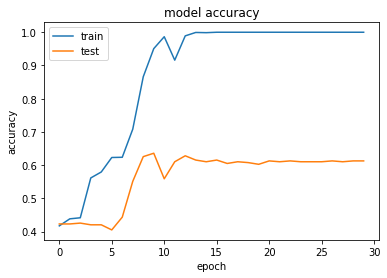

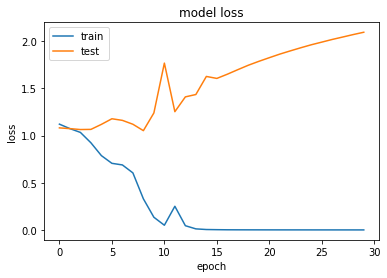

In [ ]:
plot_history(model_5_history)

#6. Порівняння результатів моделей

In [23]:
def compare_base_model_to_new_model(bayes_results, new_model_results):
  for key, value in bayes_results.items():
    print(f"Base model {key.upper()}: {value:.2f}, New model {key.upper()}: {new_model_results[key]:.2f}, Relative Improvement: {(new_model_results[key]/value-1)*100:.1f}%")

In [24]:
bayes_results = calculate_results(y_true=valid_set['Predict'],
                                     y_pred=bayes_preds)
bayes_results

{'accuracy': 69.475,
 'f1': 0.6870509340912425,
 'precision': 0.7279629123307357,
 'recall': 0.69475}

In [25]:
model_gru_results = calculate_results(y_true=valid_set['Predict'],
                                    y_pred=model_5_history)
model_gru_results

{'accuracy': 87.39166666666667,
 'f1': 0.8738919521917784,
 'precision': 0.8754721287467719,
 'recall': 0.8739166666666667}

In [26]:
compare_base_model_to_new_model(bayes_results, model_5_history)

Base model ACCURACY: 69.47, New model ACCURACY: 87.39, Relative Improvement: 25.8%
Base model PRECISION: 0.73, New model PRECISION: 0.88, Relative Improvement: 20.3%
Base model RECALL: 0.69, New model RECALL: 0.87, Relative Improvement: 25.8%
Base model F1: 0.69, New model F1: 0.87, Relative Improvement: 27.2%
